## Hard coded Policy implementation for Cart-Pole environment

First, let us import a few basic modules and set up the plotting parameters.

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import sys

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot figures and animations
%matplotlib nbagg
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

Now, let us import OpenAI gym which is a great tool-kit for developing and comparing Reinforcement Learning algorithms.

In [2]:
import gym

To illustrate the hard coding policy, a simple Cart-Pole environment is chosen. This environment has a cart that can either move to right or left and there's a pole placed vertically on top of it. The agents job is to move cart left or right to keep the pole upright as long as possible

In [3]:
gym.envs.register(
    id='CartPole-v2',
    entry_point='gym.envs.classic_control:CartPoleEnv',
    tags={'wrapper_config.TimeLimit.max_episode_steps': 60001},
    reward_threshold=100000.0,
)

In [4]:
env = gym.make("CartPole-v2")

In [5]:
obs = env.reset()

In [6]:
obs

array([-0.03090578, -0.01862305,  0.03069543,  0.00336273])

Observation (obs) is a 1D NumPy array composed of 4 floats representing the cart's horizontal position, its velocity, the angle of the pole (0 = vertical), and the angular velocity respectively.

Let us first fix the rendering issue first so that we will be able to see the animations in the notebook properly.

In [7]:
from PIL import Image, ImageDraw

try:
    from pyglet.gl import gl_info
    openai_cart_pole_rendering = True   # no problem, let's use OpenAI gym's rendering function
except Exception:
    openai_cart_pole_rendering = False  # probably no X server available, let's use our own rendering function

def render_cart_pole(env, obs):
    if openai_cart_pole_rendering:
        # use OpenAI gym's rendering function
        return env.render(mode="rgb_array")
    else:
        # rendering for the cart pole environment (in case OpenAI gym can't do it)
        img_w = 600
        img_h = 400
        cart_w = img_w // 12
        cart_h = img_h // 15
        pole_len = img_h // 3.5
        pole_w = img_w // 80 + 1
        x_width = 2
        max_ang = 0.2
        bg_col = (255, 255, 255)
        cart_col = 0x000000 # Blue Green Red
        pole_col = 0x669acc # Blue Green Red

        pos, vel, ang, ang_vel = obs
        img = Image.new('RGB', (img_w, img_h), bg_col)
        draw = ImageDraw.Draw(img)
        cart_x = pos * img_w // x_width + img_w // x_width
        cart_y = img_h * 95 // 100
        top_pole_x = cart_x + pole_len * np.sin(ang)
        top_pole_y = cart_y - cart_h // 2 - pole_len * np.cos(ang)
        draw.line((0, cart_y, img_w, cart_y), fill=0)
        draw.rectangle((cart_x - cart_w // 2, cart_y - cart_h // 2, cart_x + cart_w // 2, cart_y + cart_h // 2), fill=cart_col) # draw cart
        draw.line((cart_x, cart_y - cart_h // 2, top_pole_x, top_pole_y), fill=pole_col, width=pole_w) # draw pole
        return np.array(img)

def plot_cart_pole(env, obs):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    img = render_cart_pole(env, obs)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

Now, Let's see how the Cart-Pole environment looks.

<IPython.core.display.Javascript object>


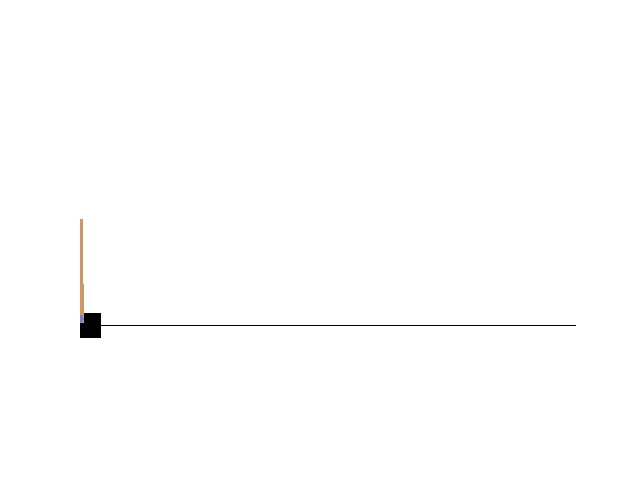

In [24]:
plot_cart_pole(env, obs)

In [9]:
env.action_space

Discrete(2)

Discrete(2) represents that there are only two possible actions: Accelerating cart towards left; Accelerating cart towards right

A few basics:

The game will be over when the pole tilts too much, not when it actually falls.

env.step(integer) --> Moves the cart to right if integer is 1 or Moves the cart to left if integer is 0.

done --> This value is True when the pole tilts too much (more than +12 degrees or less than -12 degrees)and is False if the pole's nearly upright.

Now, Let's hard code a simple policy: If the pole is tilting to the left, then push the cart to the left, and if the pole is tilting to the right, then push the cart to the right.

Let's see how good this policy is!

In [10]:
frames = []

n_max_steps = 100 #Usually it won't last long. But this is to make sure that it doesn't run infinitely.

obs = env.reset()
for step in range(n_max_steps):
    img = render_cart_pole(env, obs)
    frames.append(img)

    # hard-coded policy
    position, velocity, angle, angular_velocity = obs
    if (angle < 0):
        action = 0
    else:
        action = 1
        
    obs, reward, done, info = env.step(action)
    if done:
        break
step

32

<IPython.core.display.Javascript object>


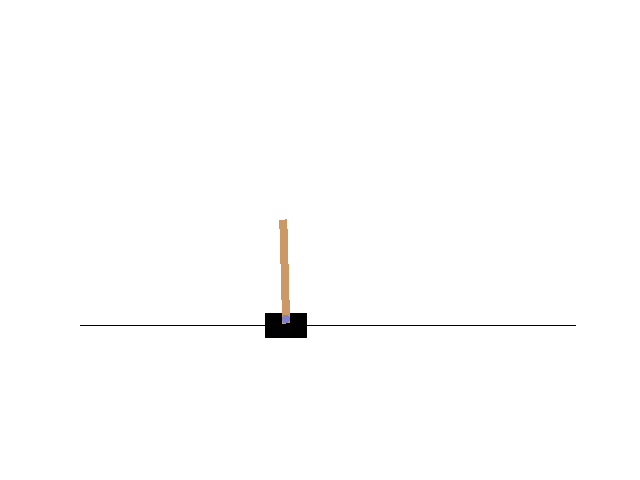

In [25]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), frames=len(frames), repeat=repeat, interval=interval)

video = plot_animation(frames)
plt.show()

We see that the system becomes unstable after just a few wobbles. The pole ends up tilted too much: Game Over! To make the system smarter than this, let's appoint a Neural Network as our new Policy Maker and see the results.

## Neural Network Policy implementation for Cart-Pole environment

Let's create a neural network that will take observations as inputs, and output the action to take for each observation. To choose an action, the network will first estimate a probability for each action, then select an action randomly according to the estimated probabilities. 

In the case of the Cart-Pole environment, there are just two possible actions (left or right), so we only need one output neuron: it will output the probability p of the action 0 (left), and of course the probability of action 1 (right) will be 1 - p.

In [12]:
import tensorflow as tf

reset_graph()

n_inputs = 4
n_hidden_1 = 8
n_hidden_2 = 16
n_outputs = 1

learning_rate = 0.1

initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
y = tf.placeholder(tf.float32, shape=[None, n_outputs])

hidden_1 = tf.layers.dense(X, n_hidden_1, activation=tf.nn.relu, kernel_initializer=initializer)
hidden_2 = tf.layers.dense(hidden_1, n_hidden_2, activation=tf.nn.relu, kernel_initializer=initializer)
logits = tf.layers.dense(hidden_2, n_outputs)
outputs = tf.nn.sigmoid(logits) # probability of action 0 (left)
p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs])
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(cross_entropy)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [13]:
n_max_steps = 60001
frames = []

with tf.Session() as sess:
    init.run()
    obs = env.reset()
    for step in range(n_max_steps):
        img = render_cart_pole(env, obs)
        frames.append(img)
        action_val = action.eval(feed_dict={X: obs.reshape(1, n_inputs)})
        obs, reward, done, info = env.step(action_val[0][0])
        if done:
            break

env.close()

<IPython.core.display.Javascript object>


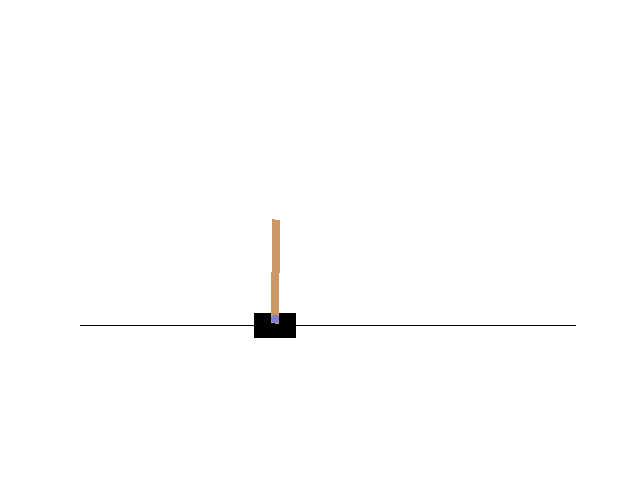

In [26]:
video = plot_animation(frames)
plt.show()

In [15]:
n_environments = 2500
n_iterations = 2500

envs = [gym.make("CartPole-v2") for _ in range(n_environments)]
observations = [env.reset() for env in envs]

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        target_probas = np.array([([1.] if obs[2] < 0 else [0.]) for obs in observations]) # if angle<0 we want proba(left)=1., or else proba(left)=0.
        action_val, _ = sess.run([action, training_op], feed_dict={X: np.array(observations), y: target_probas})
        for env_index, env in enumerate(envs):
            obs, reward, done, info = env.step(action_val[env_index][0])
            observations[env_index] = obs if not done else env.reset()
    saver.save(sess, "./my_policy_net_basic.ckpt")

for env in envs:
    env.close()

In [16]:
def render_policy_net(model_path, action, X, n_max_steps = 60001):
    frames = []
    env = gym.make("CartPole-v2")
    obs = env.reset()
    with tf.Session() as sess:
        saver.restore(sess, model_path)
        for step in range(n_max_steps):
            img = render_cart_pole(env, obs)
            frames.append(img)
            action_val = action.eval(feed_dict={X: obs.reshape(1, n_inputs)})
            obs, reward, done, info = env.step(action_val[0][0])
            if done:
                break
    env.close()
    return frames

INFO:tensorflow:Restoring parameters from ./my_policy_net_basic.ckpt


<IPython.core.display.Javascript object>


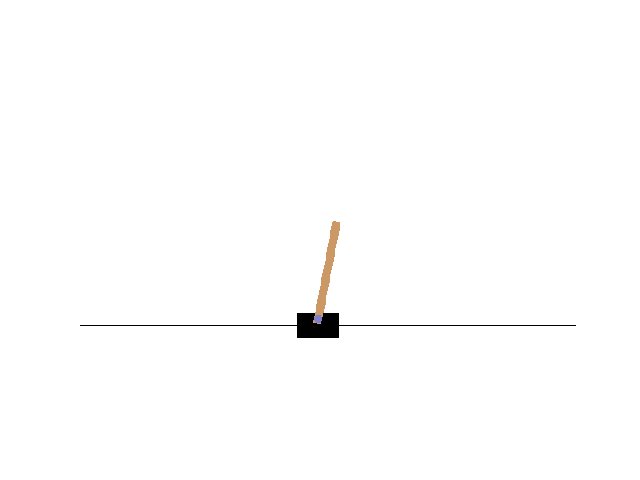

In [27]:
frames = render_policy_net("./my_policy_net_basic.ckpt", action, X)
video = plot_animation(frames)
plt.show()


In [18]:
import tensorflow as tf

reset_graph()

n_inputs = 4
n_hidden_1 = 8
n_hidden_2 = 16
n_outputs = 1

learning_rate = 0.1

initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

hidden_1 = tf.layers.dense(X, n_hidden_1, activation=tf.nn.relu, kernel_initializer=initializer)
hidden_2 = tf.layers.dense(hidden_1, n_hidden_2, activation=tf.nn.relu, kernel_initializer=initializer)
logits = tf.layers.dense(hidden_2, n_outputs)
outputs = tf.nn.sigmoid(logits)  # probability of action 0 (left)
p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs])
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

y = 1. - tf.to_float(action)
cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
optimizer = tf.train.AdamOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(cross_entropy)
gradients = [grad for grad, variable in grads_and_vars]
gradient_placeholders = []
grads_and_vars_feed = []
for grad, variable in grads_and_vars:
    gradient_placeholder = tf.placeholder(tf.float32, shape=grad.get_shape())
    gradient_placeholders.append(gradient_placeholder)
    grads_and_vars_feed.append((gradient_placeholder, variable))
training_op = optimizer.apply_gradients(grads_and_vars_feed)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [19]:
def discount_rewards(rewards, discount_rate):
    discounted_rewards = np.zeros(len(rewards))
    cumulative_rewards = 0
    for step in reversed(range(len(rewards))):
        cumulative_rewards = rewards[step] + cumulative_rewards * discount_rate
        discounted_rewards[step] = cumulative_rewards
    return discounted_rewards

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate) for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean)/reward_std for discounted_rewards in all_discounted_rewards]


In [20]:
discount_rewards([10, 0, -50], discount_rate=0.8)

array([-22., -40., -50.])

In [21]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_rate=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([ 1.26665318,  1.0727777 ])]

In [22]:
#np.random.seed(42)
n_runs = 20
sum_trials = 0
success_rate = 0
for runs in range(n_runs):
    env = gym.make("CartPole-v2")

    n_games_per_update = 10
    n_max_steps = 60001
    n_iterations = 1000
    save_iterations = 10
    discount_rate = 0.97
    maxval= 0
    step = 0
    success_flag = 0
    with tf.Session() as sess:
        init.run()
        for iteration in range(n_iterations):
            #print("\rIteration: {}, Max Times-Steps till now: {}".format(iteration, maxval), end="")
            all_rewards = []
            all_gradients = []
            for game in range(n_games_per_update):
                current_rewards = []
                current_gradients = []
                obs = env.reset()
                for step in range(n_max_steps):
                    action_val, gradients_val = sess.run([action, gradients], feed_dict={X: obs.reshape(1, n_inputs)})
                    obs, reward, done, info = env.step(action_val[0][0])
                    current_rewards.append(reward)
                    current_gradients.append(gradients_val)
                    if done:
                        break
                if(step > maxval):
                    maxval = step
                all_rewards.append(current_rewards)
                all_gradients.append(current_gradients)

            print("\rRun: {}, Iteration: {}, Max Times-Steps till now: {}".format(runs+1, iteration+1, maxval), end="")
            if(maxval >59999):
                success_flag = 1
                break
            all_rewards = discount_and_normalize_rewards(all_rewards, discount_rate=discount_rate)
            feed_dict = {}
            for var_index, gradient_placeholder in enumerate(gradient_placeholders):
                mean_gradients = np.mean([reward * all_gradients[game_index][step][var_index]
                                          for game_index, rewards in enumerate(all_rewards)
                                              for step, reward in enumerate(rewards)], axis=0)
                feed_dict[gradient_placeholder] = mean_gradients
            sess.run(training_op, feed_dict=feed_dict)
            #if iteration % save_iterations == 0:
            #    saver.save(sess, "./my_policy_net_pg.ckpt")
    env.close()
    print("\n")
    if (success_flag):
        sum_trials = sum_trials+iteration
    success_rate = success_rate + success_flag
avg_trials = sum_trials/success_rate
success_rate = (success_rate/n_runs)*100
print("\nAverage number of trials taken: {}".format(avg_trials), end="")
print("\nSuccess rate: {}".format(success_rate), end="")

Run: 1, Iteration: 28, Max Times-Steps till now: 60000

Run: 2, Iteration: 29, Max Times-Steps till now: 60000

Run: 3, Iteration: 12, Max Times-Steps till now: 60000

Run: 4, Iteration: 36, Max Times-Steps till now: 60000

Run: 5, Iteration: 30, Max Times-Steps till now: 60000

Run: 6, Iteration: 91, Max Times-Steps till now: 60000

Run: 7, Iteration: 189, Max Times-Steps till now: 60000

Run: 8, Iteration: 25, Max Times-Steps till now: 60000

Run: 9, Iteration: 18, Max Times-Steps till now: 60000

Run: 10, Iteration: 20, Max Times-Steps till now: 60000

Run: 11, Iteration: 28, Max Times-Steps till now: 60000

Run: 12, Iteration: 27, Max Times-Steps till now: 60000

Run: 13, Iteration: 22, Max Times-Steps till now: 60000

Run: 14, Iteration: 26, Max Times-Steps till now: 60000

Run: 15, Iteration: 16, Max Times-Steps till now: 60000

Run: 16, Iteration: 20, Max Times-Steps till now: 60000

Run: 17, Iteration: 22, Max Times-Steps till now: 60000

Run: 18, Iteration: 24, Max Times-Steps

INFO:tensorflow:Restoring parameters from ./my_policy_net_pg.ckpt


<IPython.core.display.Javascript object>


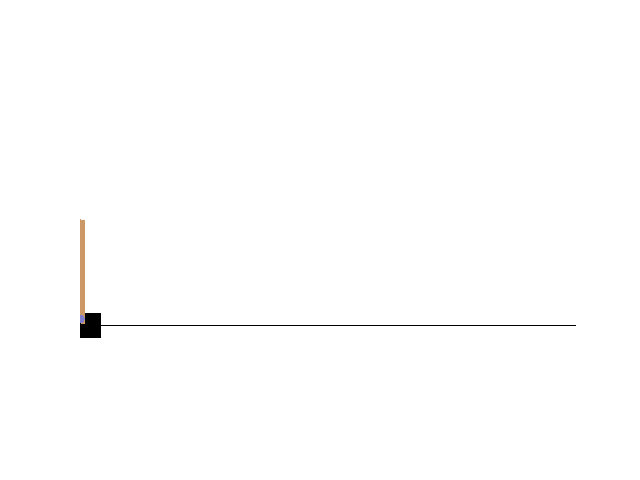

In [23]:
frames = render_policy_net("./my_policy_net_pg.ckpt", action, X, n_max_steps=2000)
video = plot_animation(frames)
plt.show()